### Preliminaries

In [2]:
# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
from matplotlib.pyplot import plot

In [3]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream,fit2
from opc_python.gerkin.fit2 import rfc_cv

In [4]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [5]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
num_descriptors = len(perceptual_headers[6:])
num_subjects = 49
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [7]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [8]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [9]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


In [10]:
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
DATA = '/Users/rgerkin/Dropbox/science/olfaction-prediction/data/'
import pandas

In [11]:
episuite = pandas.read_table('%s/DREAM_episuite_descriptors.txt' % DATA)
episuite.iloc[:,49] = 1*(episuite.iloc[:,49]=='YES ')
episuite.iloc[:,49]
episuite = episuite.iloc[:,2:].as_matrix()
episuite.shape

(476, 62)

In [12]:
verbal = pandas.read_table('%s/name_features.txt' % DATA, sep='\t', header=None)
verbal = verbal.as_matrix()[:,1:]
verbal.shape

(476, 11786)

In [13]:
morgan = pandas.read_csv('%s/morgan_sim.csv' % DATA)
morgan = morgan.as_matrix()[:,1:]
morgan.shape

(476, 2437)

In [14]:
with open('%s/derived/nspdk_r3_d4_unaug.svm' % DATA) as f:
    nspdk_dict = {}
    i = 0
    while True:
        x = f.readline()
        if(len(x)):
            key_vals = x.split(' ')[1:]
            for key_val in key_vals:
                key,val = key_val.split(':')
                if key in nspdk_dict:
                    nspdk_dict[key][all_CIDs[i]] = val
                else:
                    nspdk_dict[key] = {all_CIDs[i]:val}
            i+=1
            if i == len(all_CIDs):
                break
        else:
            break
nspdk_dict = {key:value for key,value in nspdk_dict.items() if len(value)>1}

In [15]:
nspdk = np.zeros((len(all_CIDs),len(nspdk_dict)))
for j,(feature,facts) in enumerate(nspdk_dict.items()):
    for CID,value in facts.items():
        i = all_CIDs.index(CID)
        nspdk[i,j] = value
nspdk.shape

(476, 6163)

In [16]:
nspdk_gramian = pandas.read_table('%s/derived/nspdk_r3_d4_unaug_gramian.mtx' % DATA, delimiter=' ', header=None)
nspdk_gramian = nspdk_gramian.as_matrix()[:len(all_CIDs),:]
nspdk_gramian.shape

(476, 2437)

In [17]:
molecular_data_types = ['dragon','dragon+episuite','dragon+verbal','dragon+morgan',
                                                          'dragon+nspdk','dragon+nspdk_gramian','dragon+all']
molecular_data = {mdt:molecular_data.copy() for mdt in molecular_data_types}
for i,line in enumerate(molecular_data['dragon']):
    CID = int(line[0])
    index = all_CIDs.index(CID)
    molecular_data['dragon+episuite'][i] = line + list(episuite[index])
    molecular_data['dragon+verbal'][i] = line + list(verbal[index])
    molecular_data['dragon+morgan'][i] = line + list(morgan[index])
    molecular_data['dragon+nspdk'][i] = line + list(nspdk[index])
    molecular_data['dragon+nspdk_gramian'][i] = line + list(nspdk_gramian[index])
    molecular_data['dragon+all'][i] = line + list(episuite[index]) + list(morgan[index]) + list(nspdk[index]) + list(nspdk_gramian[index])

### Create Molecular Matrix

In [18]:
X_training = {mdt:None for mdt in molecular_data_types}
X_leaderboard_other = {mdt:None for mdt in molecular_data_types}
X_leaderboard_int = {mdt:None for mdt in molecular_data_types}
X_testset_other = {mdt:None for mdt in molecular_data_types}
X_testset_int = {mdt:None for mdt in molecular_data_types}
X_all = {mdt:None for mdt in molecular_data_types}
for mdt in molecular_data_types:
    X_training[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"training")
    X_leaderboard_other[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
    X_leaderboard_int[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
    X_testset_other[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
    X_testset_int[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
    X_all[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (676x3089) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3089) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3089) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3089) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3089) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x3089) molecules by non-NaN goo

In [19]:
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject


In [20]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject


In [21]:
Y_leaderboard_noimpute,_ = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer=None)

The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject


In [22]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [23]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [24]:
Y_all_zero,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='zero')

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


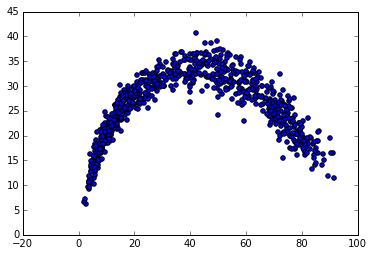

In [53]:
import matplotlib.pyplot as plt
plt.scatter(Y_all_mask['mean_std'][:,0],Y_all_mask['mean_std'][:,21])

### Data preparation

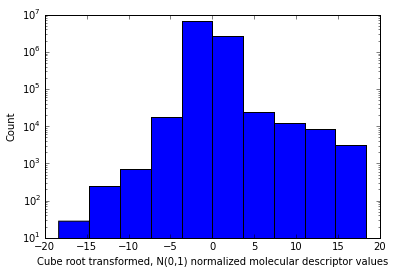

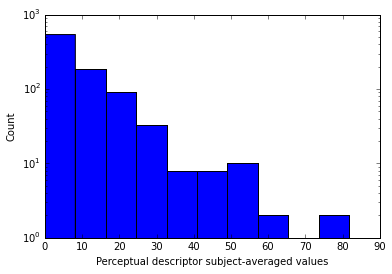

In [26]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training['dragon+all'].ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(Y_training_imp['mean_std'][:21].ravel())
plt.yscale('log')
plt.ylabel('Count')
_ = plt.xlabel('Perceptual descriptor subject-averaged values')

## Fitting and Generating Submission Files

In [27]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.cross_validation import ShuffleSplit
n_obs = len(Y_training_imp['mean_std'])

In [33]:
# What about 'all' vs 'nspdk'?  
n_splits = 10
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
results = np.zeros((42,2,n_splits))
for col in range(42):
    rfc = RandomForestRegressor(n_estimators=15,max_features=None,min_samples_leaf=1,
                                max_depth=None,oob_score=False,n_jobs=-1,random_state=0)
    for j,(train,test) in enumerate(shuffle_split):
        observed = Y_all_mask['mean_std'][:,col]
        for i,X in enumerate([X_all['dragon+all'],X_all['dragon+nspdk']]): 
            rfc.fit(X[train,:],observed[train])
            predicted = rfc.predict(X[test,:])
            results[col,i,j] = np.corrcoef(predicted,observed[test])[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)        
    print('Desc. %d: [%.3f +/- %.3f], [%.3f +/- %.3f]' % (col,means[0],sems[0],means[1],sems[1]))             

Desc. 0: [0.587 +/- 0.022], [0.600 +/- 0.020]
Desc. 1: [0.630 +/- 0.009], [0.627 +/- 0.012]
Desc. 2: [0.584 +/- 0.054], [0.582 +/- 0.059]
Desc. 3: [0.662 +/- 0.024], [0.665 +/- 0.025]
Desc. 4: [0.683 +/- 0.026], [0.678 +/- 0.027]
Desc. 5: [0.420 +/- 0.016], [0.398 +/- 0.021]
Desc. 6: [0.604 +/- 0.039], [0.610 +/- 0.040]
Desc. 7: [0.299 +/- 0.019], [0.254 +/- 0.022]
Desc. 8: [0.293 +/- 0.019], [0.275 +/- 0.028]
Desc. 9: [0.544 +/- 0.022], [0.538 +/- 0.021]
Desc. 10: [0.460 +/- 0.027], [0.479 +/- 0.025]
Desc. 11: [0.401 +/- 0.014], [0.398 +/- 0.018]
Desc. 12: [0.209 +/- 0.021], [0.205 +/- 0.020]
Desc. 13: [0.409 +/- 0.021], [0.409 +/- 0.018]
Desc. 14: [0.491 +/- 0.022], [0.510 +/- 0.023]
Desc. 15: [0.298 +/- 0.031], [0.284 +/- 0.031]
Desc. 16: [0.506 +/- 0.039], [0.518 +/- 0.037]
Desc. 17: [0.282 +/- 0.038], [0.270 +/- 0.036]
Desc. 18: [0.239 +/- 0.040], [0.229 +/- 0.044]
Desc. 19: [0.513 +/- 0.023], [0.517 +/- 0.026]
Desc. 20: [0.579 +/- 0.024], [0.578 +/- 0.021]
Desc. 21: [-0.063 +/- 0

In [34]:
# What should we train to?  Masked, median imputed, or zero (50 for ple) imputed data?   
n_splits = 35
results = np.zeros((42,3,n_splits))

shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    rfc = RandomForestRegressor(n_estimators=50,max_features=100,min_samples_leaf=1,
                                max_depth=None,oob_score=False,n_jobs=-1,random_state=0)
    for j,(train,test) in enumerate(shuffle_split):
        observed = Y_all_mask['mean_std'][test,col]
        for i,Y in enumerate([Y_all_mask,Y_all_imp,Y_all_zero]):
            rfc.fit(X_all['dragon+all'][train,:],Y['mean_std'][train,col])
            predicted = rfc.predict(X_all['dragon+all'][test,:])
            results[col,i,j] = np.corrcoef(predicted,observed)[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)        
    print('Desc. %d: [%.3f +/- %.3f], [%.3f +/- %.3f], [%.3f +/- %.3f]' % \
          (col,means[0],sems[0],means[1],sems[1],means[2],sems[2]))

Desc. 0: [0.188 +/- 0.010], [0.188 +/- 0.010], [0.188 +/- 0.010]
Desc. 1: [0.626 +/- 0.009], [0.633 +/- 0.008], [0.623 +/- 0.009]
Desc. 2: [0.567 +/- 0.032], [0.573 +/- 0.031], [0.571 +/- 0.030]
Desc. 3: [0.644 +/- 0.012], [0.643 +/- 0.013], [0.630 +/- 0.012]
Desc. 4: [0.628 +/- 0.013], [0.616 +/- 0.014], [0.617 +/- 0.014]
Desc. 5: [0.398 +/- 0.013], [0.416 +/- 0.014], [0.416 +/- 0.014]
Desc. 6: [0.621 +/- 0.020], [0.609 +/- 0.023], [0.608 +/- 0.023]
Desc. 7: [0.284 +/- 0.014], [0.290 +/- 0.015], [0.287 +/- 0.015]
Desc. 8: [0.297 +/- 0.010], [0.290 +/- 0.013], [0.290 +/- 0.013]
Desc. 9: [0.538 +/- 0.014], [0.502 +/- 0.016], [0.497 +/- 0.016]
Desc. 10: [0.506 +/- 0.021], [0.497 +/- 0.022], [0.497 +/- 0.022]
Desc. 11: [0.251 +/- 0.011], [0.226 +/- 0.011], [0.226 +/- 0.011]
Desc. 12: [0.194 +/- 0.015], [0.208 +/- 0.017], [0.208 +/- 0.017]
Desc. 13: [0.403 +/- 0.014], [0.408 +/- 0.015], [0.406 +/- 0.015]
Desc. 14: [0.477 +/- 0.018], [0.471 +/- 0.018], [0.470 +/- 0.018]
Desc. 15: [0.258 +/-

In [35]:
# When do we want ExtraTrees instead of the usual RandomForest?
n_splits = 10
results = np.zeros((42,2,n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    rfc = RandomForestRegressor(n_estimators=20,max_features=None,min_samples_leaf=1,
                                max_depth=None,oob_score=False,n_jobs=-1,random_state=0)
    etc = ExtraTreesRegressor(n_estimators=20,max_features=None,min_samples_leaf=1,
                                max_depth=None,n_jobs=-1,random_state=0)
    for j,(train,test) in enumerate(shuffle_split):
        for i,estimator in enumerate([etc,rfc]):
            X = X_all['dragon+all']
            observed = Y_all_mask['mean_std'][:,col]
            estimator.fit(X[train,:],observed[train])
            predicted = estimator.predict(X[test,:])
            results[col,i,j] = np.corrcoef(predicted,observed[test])[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)
    print('Desc. %d: [%.3f +/- %.3f], [%.3f +/- %.3f]' % \
          (col,means[0],sems[0],means[1],sems[1]))

Desc. 0: [0.664 +/- 0.020], [0.593 +/- 0.020]
Desc. 1: [0.626 +/- 0.011], [0.635 +/- 0.009]
Desc. 2: [0.557 +/- 0.071], [0.586 +/- 0.057]
Desc. 3: [0.678 +/- 0.024], [0.669 +/- 0.023]
Desc. 4: [0.705 +/- 0.022], [0.690 +/- 0.025]
Desc. 5: [0.365 +/- 0.017], [0.424 +/- 0.014]
Desc. 6: [0.557 +/- 0.048], [0.608 +/- 0.038]
Desc. 7: [0.247 +/- 0.020], [0.303 +/- 0.022]
Desc. 8: [0.269 +/- 0.024], [0.302 +/- 0.021]
Desc. 9: [0.531 +/- 0.027], [0.544 +/- 0.023]
Desc. 10: [0.426 +/- 0.034], [0.462 +/- 0.030]
Desc. 11: [0.415 +/- 0.019], [0.414 +/- 0.017]
Desc. 12: [0.180 +/- 0.020], [0.216 +/- 0.022]
Desc. 13: [0.395 +/- 0.014], [0.406 +/- 0.022]
Desc. 14: [0.494 +/- 0.021], [0.499 +/- 0.021]
Desc. 15: [0.289 +/- 0.023], [0.301 +/- 0.029]
Desc. 16: [0.494 +/- 0.044], [0.512 +/- 0.037]
Desc. 17: [0.260 +/- 0.042], [0.295 +/- 0.038]
Desc. 18: [0.235 +/- 0.036], [0.244 +/- 0.041]
Desc. 19: [0.494 +/- 0.026], [0.519 +/- 0.022]
Desc. 20: [0.574 +/- 0.025], [0.583 +/- 0.024]
Desc. 21: [-0.060 +/- 0

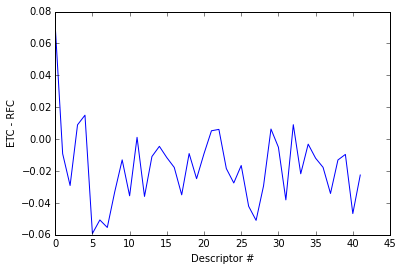

In [36]:
# Answer: Probably only for intensity.  
means = results[:,:,:].mean(axis=2)
sems = results[:,:,:].std(axis=2)/np.sqrt(n_splits)
plt.plot(means[:,0] - means[:,1])
plt.xlabel("Descriptor #")
plt.ylabel("ETC - RFC")

In [29]:
# How does performance increase with the number of features?  
n_splits = 3
n_features = [10,33,100,333,1000,3333,13914]
#results = np.zeros((42,len(n_features),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    for i,max_features in enumerate(n_features):
        rfc = RandomForestRegressor(n_estimators=100,max_features=max_features,min_samples_leaf=1,
                                max_depth=None,oob_score=False,n_jobs=-1,random_state=0)
        for j,(train,test) in enumerate(shuffle_split):
            X = X_all['dragon+all']
            observed = Y_all_mask['mean_std'][:,col]
            rfc.fit(X[train,:],observed[train])
            predicted = rfc.predict(X[test,:])
            results[col,i,j] = np.corrcoef(predicted,observed[test])[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)
    print(('Desc. %d:'+len(n_features)*' [%.3f],') % \
          tuple([col]+[means[i] for i in range(len(n_features))]))

Desc. 3: [0.677], [0.689], [0.690], [0.692], [0.694], [0.696], [0.711],
Desc. 4: [0.645], [0.660], [0.665], [0.677], [0.675], [0.684], [0.727],
Desc. 5: [0.399], [0.415], [0.409], [0.416], [0.407], [0.408], [0.413],
Desc. 6: [0.623], [0.640], [0.658], [0.672], [0.680], [0.685], [0.675],
Desc. 7: [0.312], [0.308], [0.319], [0.324], [0.327], [0.347], [0.355],
Desc. 8: [0.304], [0.303], [0.313], [0.298], [0.315], [0.314], [0.327],
Desc. 9: [0.548], [0.561], [0.562], [0.566], [0.566], [0.577], [0.574],
Desc. 10: [0.378], [0.383], [0.384], [0.394], [0.395], [0.399], [0.417],
Desc. 11: [0.283], [0.289], [0.298], [0.312], [0.357], [0.399], [0.452],
Desc. 12: [0.159], [0.167], [0.168], [0.175], [0.162], [0.157], [0.173],
Desc. 13: [0.400], [0.406], [0.402], [0.396], [0.409], [0.415], [0.422],
Desc. 14: [0.481], [0.481], [0.484], [0.481], [0.479], [0.481], [0.486],
Desc. 15: [0.320], [0.325], [0.336], [0.338], [0.338], [0.352], [0.382],
Desc. 16: [0.527], [0.536], [0.529], [0.529], [0.527], [0.

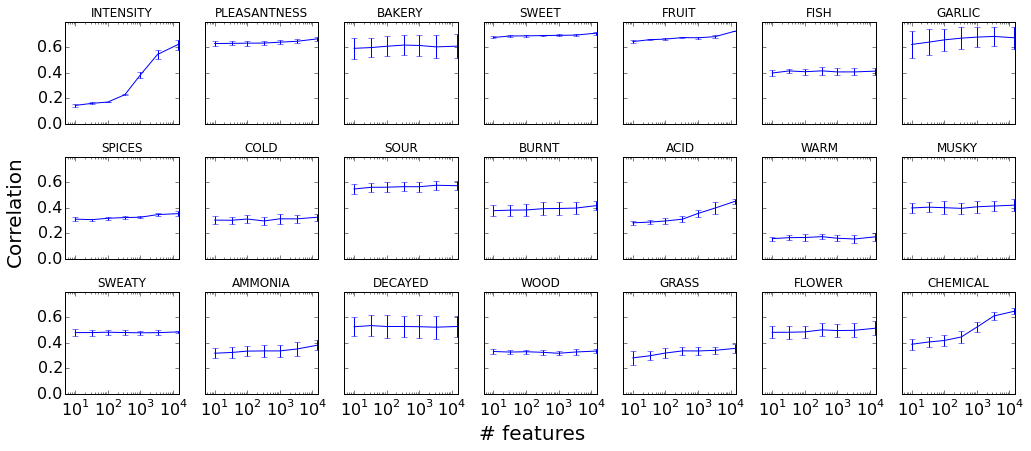

In [47]:
fig,axes = plt.subplots(3,7,sharex=True,sharey=True,figsize=(14,6))
for col,ax in enumerate(axes.flat):
    ax.errorbar(n_features,results[col,:,:].mean(axis=1),results[col,:,:].std(axis=1)/np.sqrt(n_splits))
    ax.set_xlim(5,15000)
    ax.set_ylim(0,0.8)
    ax.set_yticks(np.linspace(0,0.6,4))
    ax.set_yticklabels([_ for _ in np.linspace(0,0.6,4)],size=16)
    ax.set_xticklabels(n_features,size=16)
    ax.set_xscale('log')
    ax.set_title(perceptual_headers[col+6].split('/')[1 if col==1 else 0])
plt.tight_layout()
fig.text(0.5, -0.025, '# features', ha='center', size=20)
fig.text(-0.02, 0.5, 'Correlation', va='center', rotation='vertical', size=20)

In [1]:
results[:,-1,:].mean(axis=1)# - results[:,2,:].mean(axis=1)

NameError: name 'results' is not defined

In [42]:
# Does having more samples per leaf or less depth help?  
n_splits = 12
n_samples_leaf = [1,4,16,64]
n_depth = [2,6,15,32,None]
#results = np.zeros((42,len(n_samples_leaf),len(n_depth),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(3,42):
    for i,min_samples_leaf in enumerate(n_samples_leaf):
        for j,max_depth in enumerate(n_depth):
            rfc = RandomForestRegressor(n_estimators=25,max_features=None,
                                            min_samples_leaf=min_samples_leaf,
                                            max_depth=max_depth,oob_score=False,
                                            n_jobs=-1,random_state=0)
            X = X_all['dragon+all']
            Y = Y_all_mask['mean_std'][:,col]
            for k,(train,test) in enumerate(shuffle_split):
                observed = Y[test]
                rfc.fit(X[train,:],Y[train])
                predicted = rfc.predict(X[test,:])
                results[col,i,j,k] = np.corrcoef(predicted,observed)[1,0]
            mean = results[col,i,j,:].mean()
            sem = results[col,i,j,:].std()/np.sqrt(n_splits)
            print('Feature %d: %s min samples per leaf, %s max depth: %.3f +/- %.3f' % (col,min_samples_leaf,max_depth,mean,sem))

Feature 3: 1 min samples per leaf, 2 max depth: 0.258 +/- 0.083
Feature 3: 1 min samples per leaf, 6 max depth: 0.310 +/- 0.095
Feature 3: 1 min samples per leaf, 15 max depth: 0.314 +/- 0.096
Feature 3: 1 min samples per leaf, 32 max depth: 0.315 +/- 0.096
Feature 3: 1 min samples per leaf, None max depth: 0.315 +/- 0.096
Feature 3: 4 min samples per leaf, 2 max depth: 0.259 +/- 0.083
Feature 3: 4 min samples per leaf, 6 max depth: 0.301 +/- 0.092
Feature 3: 4 min samples per leaf, 15 max depth: 0.306 +/- 0.093
Feature 3: 4 min samples per leaf, 32 max depth: 0.306 +/- 0.093
Feature 3: 4 min samples per leaf, None max depth: 0.306 +/- 0.093
Feature 3: 16 min samples per leaf, 2 max depth: 0.248 +/- 0.079
Feature 3: 16 min samples per leaf, 6 max depth: 0.278 +/- 0.085
Feature 3: 16 min samples per leaf, 15 max depth: 0.278 +/- 0.085
Feature 3: 16 min samples per leaf, 32 max depth: 0.278 +/- 0.085
Feature 3: 16 min samples per leaf, None max depth: 0.278 +/- 0.085
Feature 3: 64 min sa

In [45]:
import pickle
with open('data.pickle','wb') as f:
    pickle.dump(results,f)

In [59]:
results2[:,0,3]

array([  0.00000000e+00,   0.00000000e+00,  -1.69723722e-04,
         0.00000000e+00,   1.69704999e-03,  -1.61904458e-03,
         0.00000000e+00,   1.37203856e-04,   1.99234317e-04,
         0.00000000e+00,   3.85266740e-05,  -1.39141356e-04,
        -3.18332595e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -2.32184524e-03,  -2.05099956e-05,
         2.70573941e-04,   0.00000000e+00,   0.00000000e+00,
        -1.02199441e-04,  -3.67148617e-04,  -2.51297232e-05,
         0.00000000e+00,   0.00000000e+00,  -2.10769807e-03,
         0.00000000e+00,  -1.48029305e-04,   2.95277257e-04,
         3.69270851e-05,   0.00000000e+00,   0.00000000e+00,
        -9.05272440e-05,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.19217603e-05,  -1.43068347e-04,
        -2.40110541e-04,   0.00000000e+00,   0.00000000e+00])

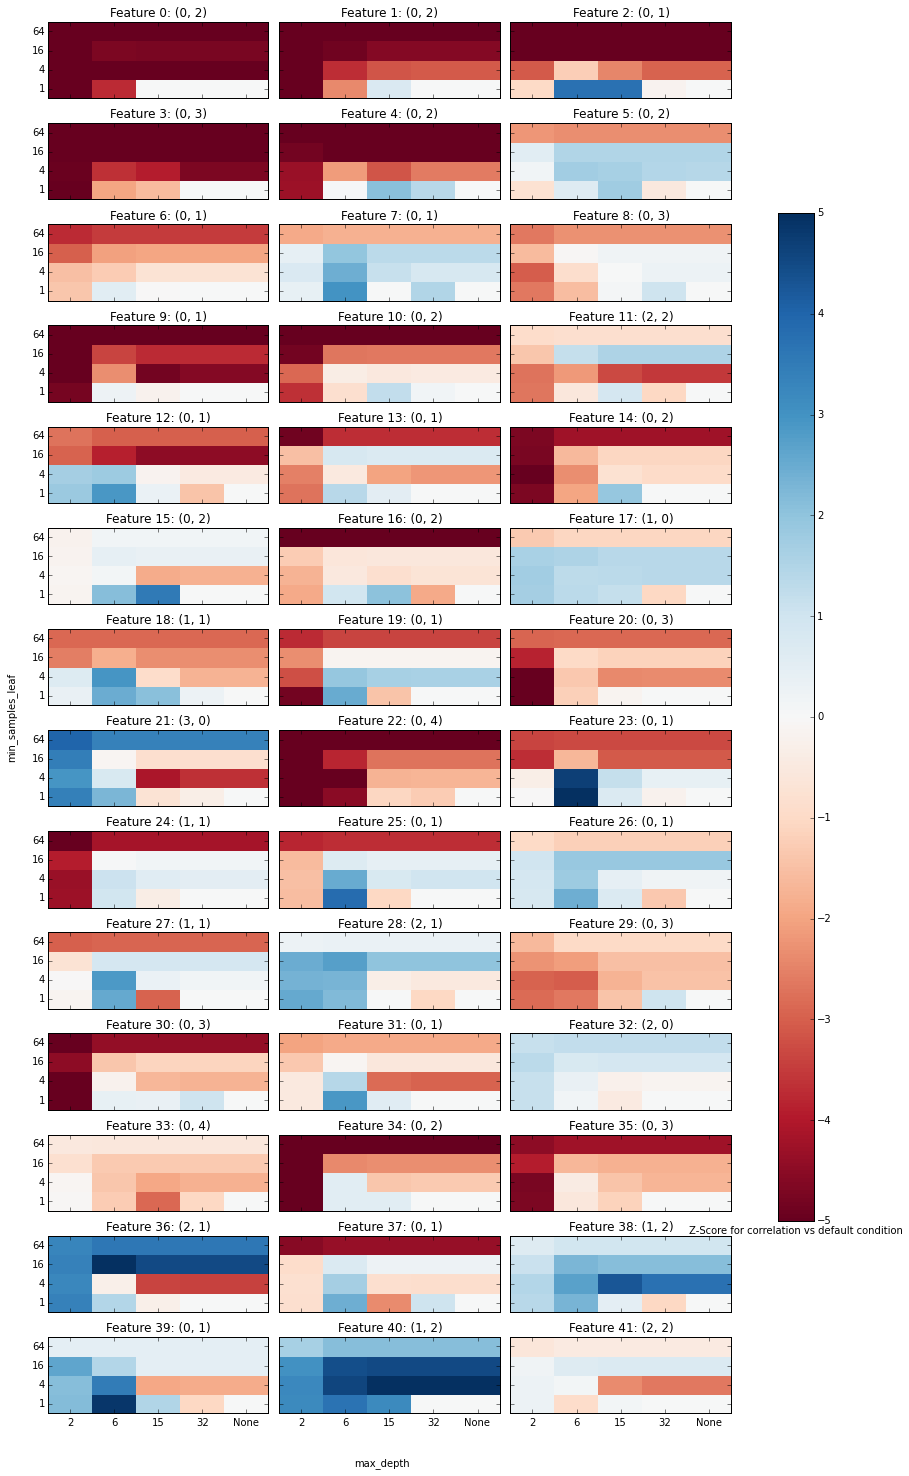

In [87]:
results2 = results - np.tile(results[:,0:1,4:5,:],(1,4,5,1)) # Subtract the no max depth, no min sample condition.  
results2 = results2[:,:,:,:n_splits] # Only 12 splits used.  
results2 = results2.mean(axis=3) / (results2.std(axis=3)/np.sqrt(n_splits)) 
results2[np.where(np.isnan(results2))] = 0

fig,axes = plt.subplots(14,3,sharex=True,sharey=True,figsize=(10,20))
for col,ax in enumerate(axes.flat):
    im = ax.pcolormesh(results2[col,:,:],vmin=-5,vmax=5,cmap='RdBu')
    ax.set_xticks(np.arange(5)+0.5)
    ax.set_xticklabels(n_depth)
    ax.set_yticks(np.arange(4)+0.5)
    ax.set_yticklabels(n_samples_leaf)
    _ = results2[col,:,:]
    ax.set_title('Feature %d: %s' % (col,np.unravel_index(np.argmax(_), _.shape)))
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar_ax.set_xlabel('Z-Score for correlation vs default condition')
plt.colorbar(im, cax=cbar_ax)
fig.text(0.5, -0.02, 'max_depth', ha='center')
fig.text(-0.02, 0.5, 'min_samples_leaf', va='center', rotation='vertical')
plt.tight_layout()

In [89]:
n_splits = 15
n_features = [50,200,800,3200,None]
n_depth = [2,6,15,32,None]
results_f_d = np.zeros((21,len(n_features),len(n_depth),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in [12,15,18]:
    for i,max_features in enumerate(n_features):
        for j,max_depth in enumerate(n_depth):
            rfc = RandomForestRegressor(n_estimators=25,max_features=max_features,
                                            min_samples_leaf=1,
                                            max_depth=max_depth,oob_score=False,
                                            n_jobs=-1,random_state=0)
            X = X_all['dragon+all']
            Y = Y_all_mask['mean_std'][:,col]
            for k,(train,test) in enumerate(shuffle_split):
                observed = Y[test]
                rfc.fit(X[train,:],Y[train])
                predicted = rfc.predict(X[test,:])
                results_f_d[col,i,j,k] = np.corrcoef(predicted,observed)[1,0]
            mean = results_f_d[col,i,j,:].mean()
            sem = results_f_d[col,i,j,:].std()/np.sqrt(n_splits)
            print('Feature %d: %s min samples per leaf, %s max depth: %.3f +/- %.3f' % (col,max_features,max_depth,mean,sem))


Feature 12: 50 min samples per leaf, 2 max depth: 0.190 +/- 0.031
Feature 12: 50 min samples per leaf, 6 max depth: 0.223 +/- 0.027
Feature 12: 50 min samples per leaf, 15 max depth: 0.182 +/- 0.024
Feature 12: 50 min samples per leaf, 32 max depth: 0.186 +/- 0.023
Feature 12: 50 min samples per leaf, None max depth: 0.186 +/- 0.023
Feature 12: 200 min samples per leaf, 2 max depth: 0.218 +/- 0.034
Feature 12: 200 min samples per leaf, 6 max depth: 0.226 +/- 0.024
Feature 12: 200 min samples per leaf, 15 max depth: 0.194 +/- 0.022
Feature 12: 200 min samples per leaf, 32 max depth: 0.200 +/- 0.023
Feature 12: 200 min samples per leaf, None max depth: 0.201 +/- 0.023
Feature 12: 800 min samples per leaf, 2 max depth: 0.217 +/- 0.037
Feature 12: 800 min samples per leaf, 6 max depth: 0.226 +/- 0.024
Feature 12: 800 min samples per leaf, 15 max depth: 0.195 +/- 0.021
Feature 12: 800 min samples per leaf, 32 max depth: 0.188 +/- 0.022
Feature 12: 800 min samples per leaf, None max depth: 0

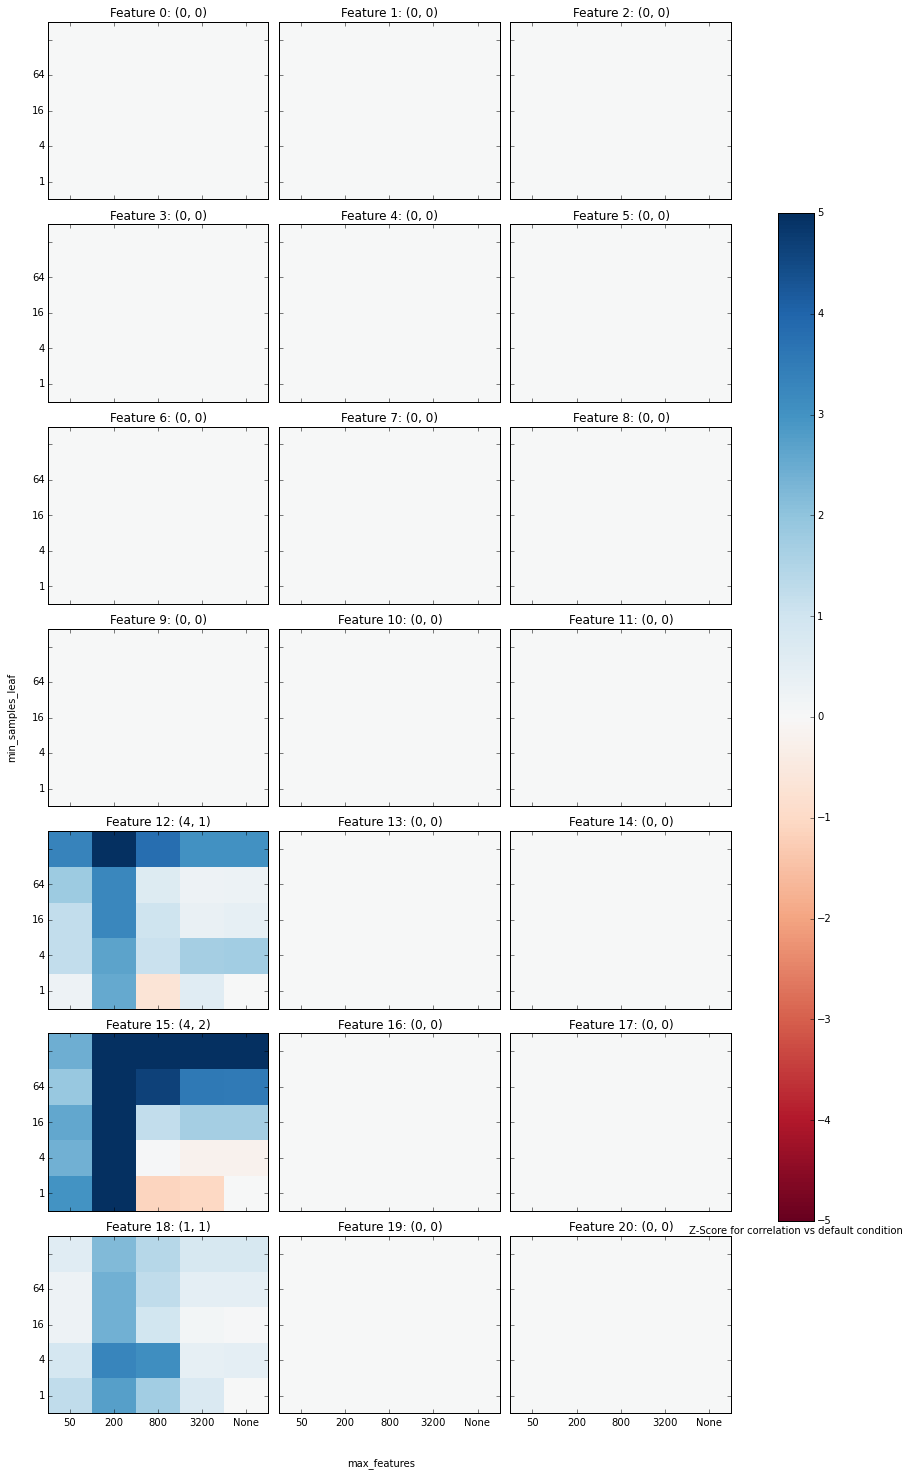

In [93]:
results2 = results_f_d - np.tile(results_f_d[:,0:1,4:5,:],(1,5,5,1)) # Subtract the no max depth, no min sample condition.  
results2 = results2[:,:,:,:n_splits] # Only 12 splits used.  
results2 = results2.mean(axis=3) / (results2.std(axis=3)/np.sqrt(n_splits)) 
results2[np.where(np.isnan(results2))] = 0

fig,axes = plt.subplots(7,3,sharex=True,sharey=True,figsize=(10,20))
for col,ax in enumerate(axes.flat):
    im = ax.pcolormesh(results2[col,:,:],vmin=-5,vmax=5,cmap='RdBu')
    ax.set_xticks(np.arange(5)+0.5)
    ax.set_xticklabels(n_features)
    ax.set_yticks(np.arange(5)+0.5)
    ax.set_yticklabels(n_samples_leaf)
    _ = results2[col,:,:]
    ax.set_title('Feature %d: %s' % (col,np.unravel_index(np.argmax(_), _.shape)))
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar_ax.set_xlabel('Z-Score for correlation vs default condition')
plt.colorbar(im, cax=cbar_ax)
fig.text(0.5, -0.02, 'max_features', ha='center')
fig.text(-0.02, 0.5, 'min_samples_leaf', va='center', rotation='vertical')
plt.tight_layout()

In [102]:
# Does having more samples per leaf or less depth help?  
n_splits = 10
n_samples_leaf = [1,4,16,64]
n_depth = [2,6,15,32,None]
#results_s_d = np.zeros((42,len(n_samples_leaf),len(n_depth),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    for i,min_samples_leaf in enumerate(n_samples_leaf):
        for j,max_depth in enumerate(n_depth):
            rfc = RandomForestRegressor(n_estimators=25,max_features=200,
                                            min_samples_leaf=min_samples_leaf,
                                            max_depth=max_depth,oob_score=False,
                                            n_jobs=-1,random_state=0)
            X = X_all['dragon+all']
            Y = Y_all_mask['mean_std'][:,col]
            for k,(train,test) in enumerate(shuffle_split):
                observed = Y[test]
                rfc.fit(X[train,:],Y[train])
                predicted = rfc.predict(X[test,:])
                results_s_d[col,i,j,k] = np.corrcoef(predicted,observed)[1,0]
            mean = results_s_d[col,i,j,:].mean()
            sem = results_s_d[col,i,j,:].std()/np.sqrt(n_splits)
            print('Feature %d: %s min samples per leaf, %s max depth: %.3f +/- %.3f' % (col,min_samples_leaf,max_depth,mean,sem))

Feature 0: 1 min samples per leaf, 2 max depth: 0.233 +/- 0.027
Feature 0: 1 min samples per leaf, 6 max depth: 0.207 +/- 0.019
Feature 0: 1 min samples per leaf, 15 max depth: 0.178 +/- 0.019
Feature 0: 1 min samples per leaf, 32 max depth: 0.192 +/- 0.019
Feature 0: 1 min samples per leaf, None max depth: 0.192 +/- 0.019
Feature 0: 4 min samples per leaf, 2 max depth: 0.234 +/- 0.026
Feature 0: 4 min samples per leaf, 6 max depth: 0.191 +/- 0.020
Feature 0: 4 min samples per leaf, 15 max depth: 0.135 +/- 0.019
Feature 0: 4 min samples per leaf, 32 max depth: 0.134 +/- 0.018
Feature 0: 4 min samples per leaf, None max depth: 0.134 +/- 0.018
Feature 0: 16 min samples per leaf, 2 max depth: 0.209 +/- 0.025
Feature 0: 16 min samples per leaf, 6 max depth: 0.197 +/- 0.029
Feature 0: 16 min samples per leaf, 15 max depth: 0.176 +/- 0.031
Feature 0: 16 min samples per leaf, 32 max depth: 0.176 +/- 0.031
Feature 0: 16 min samples per leaf, None max depth: 0.176 +/- 0.031
Feature 0: 64 min sa

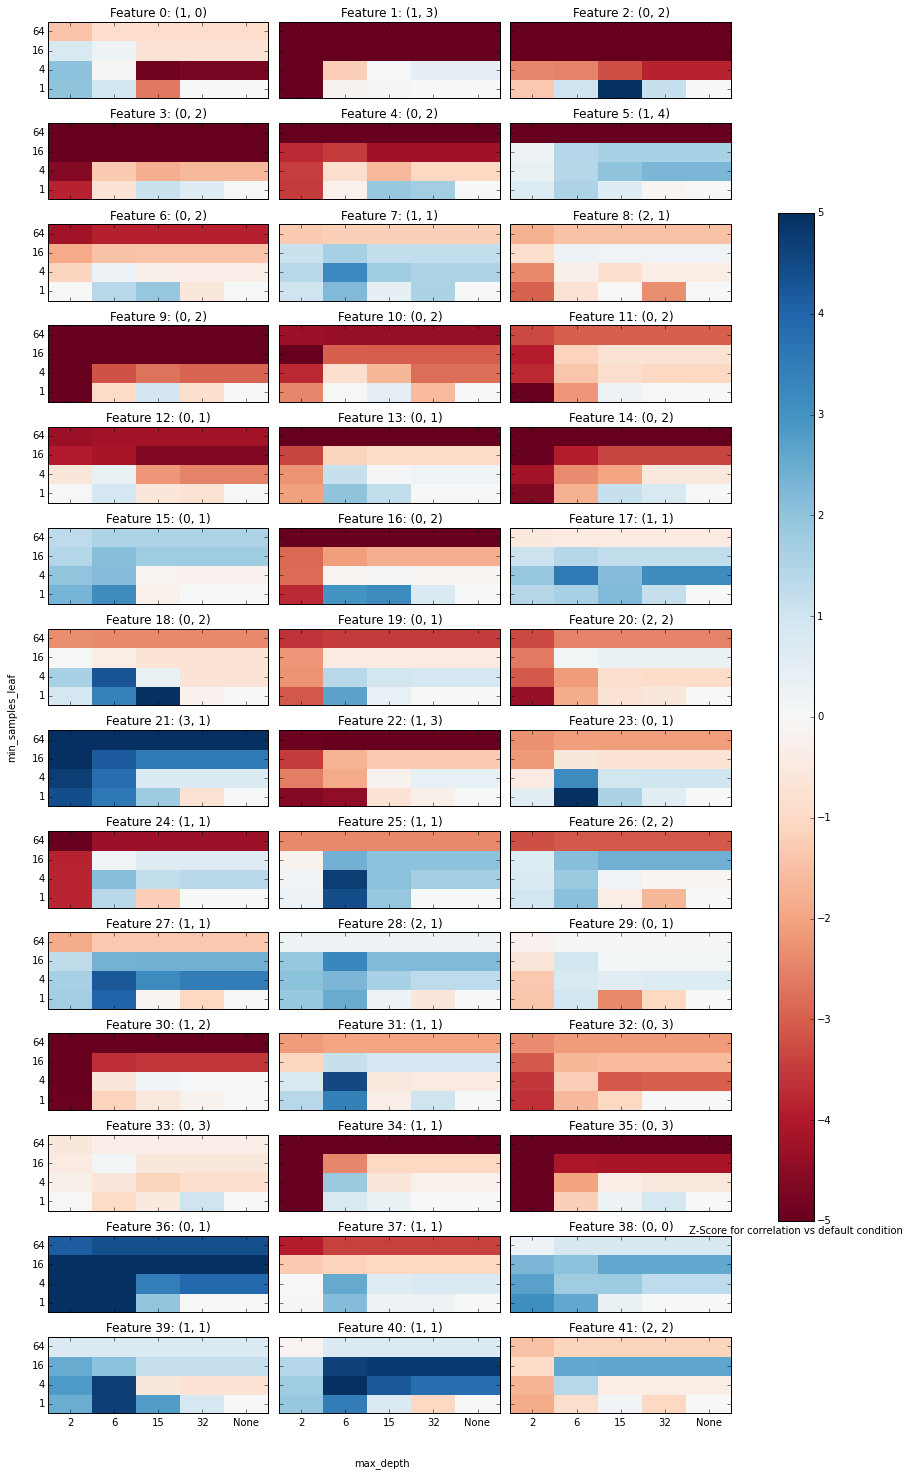

In [103]:
results2 = results_s_d - np.tile(results_s_d[:,0:1,4:5,:],(1,4,5,1)) # Subtract the no max depth, no min sample condition.  
results2 = results2[:,:,:,:n_splits] # Only 12 splits used.  
results2 = results2.mean(axis=3) / (results2.std(axis=3)/np.sqrt(n_splits)) 
results2[np.where(np.isnan(results2))] = 0

fig,axes = plt.subplots(14,3,sharex=True,sharey=True,figsize=(10,20))
for col,ax in enumerate(axes.flat):
    im = ax.pcolormesh(results2[col,:,:],vmin=-5,vmax=5,cmap='RdBu')
    ax.set_xticks(np.arange(5)+0.5)
    ax.set_xticklabels(n_depth)
    ax.set_yticks(np.arange(4)+0.5)
    ax.set_yticklabels(n_samples_leaf)
    _ = results2[col,:,:]
    ax.set_title('Feature %d: %s' % (col,np.unravel_index(np.argmax(_), _.shape)))
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar_ax.set_xlabel('Z-Score for correlation vs default condition')
plt.colorbar(im, cax=cbar_ax)
fig.text(0.5, -0.02, 'max_depth', ha='center')
fig.text(-0.02, 0.5, 'min_samples_leaf', va='center', rotation='vertical')
plt.tight_layout()

In [109]:
import pickle
with open('data.pickle','rb') as f:
    results_s_d_nomax = pickle.load(f)

In [132]:
for col in range(42):
    nomax = results_s_d_nomax[col,:,:,:10].mean(axis=2)
    nomax_argmax = np.unravel_index(np.argmax(nomax), nomax.shape)
    
    x200 = results_s_d_200[col,:,:,:10].mean(axis=2)
    x200_argmax = np.unravel_index(np.argmax(x200), x200.shape)
    
    results_diff = results_s_d_nomax[col,nomax_argmax[0],nomax_argmax[1],:10] \
                 - results_s_d_200[col,x200_argmax[0],x200_argmax[1],:10]
    mean = results_diff.mean()
    sem = results_diff.std()/np.sqrt(10)
    
    print('%d: %.3f +/- %.3f, z=%.1f' % (col,mean,sem,mean/sem))

0: 0.373 +/- 0.027, z=13.6
1: 0.031 +/- 0.006, z=5.2
2: 0.024 +/- 0.008, z=3.0
3: 0.016 +/- 0.006, z=2.6
4: 0.037 +/- 0.006, z=6.2
5: 0.001 +/- 0.018, z=0.1
6: 0.010 +/- 0.016, z=0.7
7: -0.004 +/- 0.016, z=-0.2
8: 0.019 +/- 0.022, z=0.9
9: 0.014 +/- 0.006, z=2.4
10: 0.015 +/- 0.008, z=1.9
11: 0.167 +/- 0.019, z=8.8
12: 0.028 +/- 0.020, z=1.4
13: 0.006 +/- 0.006, z=1.0
14: -0.004 +/- 0.006, z=-0.7
15: 0.021 +/- 0.024, z=0.9
16: 0.001 +/- 0.015, z=0.0
17: -0.015 +/- 0.019, z=-0.8
18: -0.011 +/- 0.014, z=-0.8
19: -0.004 +/- 0.010, z=-0.4
20: 0.200 +/- 0.021, z=9.7
21: -0.023 +/- 0.009, z=-2.5
22: 0.022 +/- 0.008, z=2.8
23: -0.010 +/- 0.007, z=-1.5
24: -0.010 +/- 0.007, z=-1.4
25: 0.017 +/- 0.005, z=3.5
26: 0.004 +/- 0.008, z=0.5
27: 0.010 +/- 0.011, z=0.9
28: 0.021 +/- 0.019, z=1.1
29: 0.011 +/- 0.012, z=0.9
30: 0.004 +/- 0.011, z=0.4
31: 0.006 +/- 0.012, z=0.5
32: 0.153 +/- 0.024, z=6.5
33: 0.016 +/- 0.015, z=1.0
34: -0.002 +/- 0.005, z=-0.3
35: 0.014 +/- 0.011, z=1.2
36: 0.004 +/- 0.009

In [137]:
params = ("1:None:None:1,1:200:None:4;"
"9:None:32:1,9:200:15:1;"
"10:None:15:1,10:200:15:1;"
"12:None:6:1,12:200:6:1;"
"13:None:6:1,13:200:6:1;"
"15:None:15:1,15:200:6:1;"
"22:None:None:1,22:200:None:2;"
"28:None:6:1,28:200:6:16")

X = X_all['dragon+all']
n_splits = 25
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=1)
for line in params.split(';'):
    col = int(line[0])
    Y = Y_all_mask['mean_std'][:,col]   
    results_200_vs_max = np.zeros((n_splits,2))
    for k,(train,test) in enumerate(shuffle_split):
        for i,param_set in enumerate(line.split(',')):
            print(col,k,i)
            col,max_features,max_depth,min_samples_leaf = [None if _=='None' else int(_) for _ in param_set.split(':')]
            observed = Y[test]
            rfc = RandomForestRegressor(n_estimators=25,max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            max_depth=max_depth,oob_score=False,
                                            n_jobs=-1,random_state=0)
            rfc.fit(X[train,:],Y[train])
            predicted = rfc.predict(X[test,:])
            results_200_vs_max[k,i] = np.corrcoef(predicted,observed)[1,0]
    diff = results_200_vs_max[:,0] - results_200_vs_max[:,1]
    print('Feature %d: %.3f +/- %.3f' % (col,diff.mean(),diff.std()/np.sqrt(n_splits)))

1 0 0
1 0 1
1 1 0
1 1 1
1 2 0
1 2 1
1 3 0
1 3 1
1 4 0
1 4 1
1 5 0
1 5 1
1 6 0
1 6 1
1 7 0
1 7 1
1 8 0
1 8 1
1 9 0
1 9 1
1 10 0
1 10 1
1 11 0
1 11 1
1 12 0
1 12 1
1 13 0
1 13 1
1 14 0
1 14 1
1 15 0
1 15 1
1 16 0
1 16 1
1 17 0
1 17 1
1 18 0
1 18 1
1 19 0
1 19 1
1 20 0
1 20 1
1 21 0
1 21 1
1 22 0
1 22 1
1 23 0
1 23 1
1 24 0
1 24 1
Feature 1: 0.034 +/- 0.005
9 0 0
9 0 1
9 1 0
9 1 1
9 2 0
9 2 1
9 3 0
9 3 1
9 4 0
9 4 1
9 5 0
9 5 1
9 6 0
9 6 1
9 7 0
9 7 1
9 8 0
9 8 1
9 9 0
9 9 1
9 10 0
9 10 1
9 11 0
9 11 1
9 12 0
9 12 1
9 13 0
9 13 1
9 14 0
9 14 1
9 15 0
9 15 1
9 16 0
9 16 1
9 17 0
9 17 1
9 18 0
9 18 1
9 19 0
9 19 1
9 20 0
9 20 1
9 21 0
9 21 1
9 22 0
9 22 1
9 23 0
9 23 1
9 24 0
9 24 1
Feature 9: 0.009 +/- 0.004
1 0 0
10 0 1
10 1 0
10 1 1
10 2 0
10 2 1
10 3 0
10 3 1
10 4 0
10 4 1
10 5 0
10 5 1
10 6 0
10 6 1
10 7 0
10 7 1
10 8 0
10 8 1
10 9 0
10 9 1
10 10 0
10 10 1
10 11 0
10 11 1
10 12 0
10 12 1
10 13 0
10 13 1
10 14 0
10 14 1
10 15 0
10 15 1
10 16 0
10 16 1
10 17 0
10 17 1
10 18 0
10 18 1
10 

IndexError: string index out of range

In [120]:
results_n_estimators = np.zeros((42,4,n_splits))
for col in range(42):
    for i,n_estimators in enumerate([20,60,240,960]):
        rfc = RandomForestRegressor(n_estimators=n_estimators,max_features=200,
                                    min_samples_leaf=1,
                                    max_depth=10,oob_score=False,
                                    n_jobs=-1,random_state=0)
        X = X_all['dragon+all']
        Y = Y_all_mask['mean_std'][:,col]
        temp = []
        for k,(train,test) in enumerate(shuffle_split):
            observed = Y[test]
            rfc.fit(X[train,:],Y[train])
            predicted = rfc.predict(X[test,:])
            results_n_estimators[col,i,k] = np.corrcoef(predicted,observed)[1,0]
        mean = np.mean(results_n_estimators[col,i,:])
        sem = np.std(results_n_estimators[col,i,:])/np.sqrt(n_splits)
        print('Feature %d, %d estimators: %.3f +/- %.3f' % (col,n_estimators,mean,sem))

Feature 0, 20 estimators: 0.162 +/- 0.018
Feature 0, 60 estimators: 0.166 +/- 0.016
Feature 0, 240 estimators: 0.170 +/- 0.017
Feature 0, 960 estimators: 0.172 +/- 0.016
Feature 1, 20 estimators: 0.611 +/- 0.017
Feature 1, 60 estimators: 0.623 +/- 0.014
Feature 1, 240 estimators: 0.624 +/- 0.014
Feature 1, 960 estimators: 0.625 +/- 0.013
Feature 2, 20 estimators: 0.595 +/- 0.066
Feature 2, 60 estimators: 0.611 +/- 0.062
Feature 2, 240 estimators: 0.612 +/- 0.063
Feature 2, 960 estimators: 0.613 +/- 0.063
Feature 3, 20 estimators: 0.651 +/- 0.027
Feature 3, 60 estimators: 0.661 +/- 0.024
Feature 3, 240 estimators: 0.671 +/- 0.024
Feature 3, 960 estimators: 0.673 +/- 0.024
Feature 4, 20 estimators: 0.643 +/- 0.021
Feature 4, 60 estimators: 0.653 +/- 0.019
Feature 4, 240 estimators: 0.662 +/- 0.018
Feature 4, 960 estimators: 0.664 +/- 0.018
Feature 5, 20 estimators: 0.414 +/- 0.017
Feature 5, 60 estimators: 0.429 +/- 0.015
Feature 5, 240 estimators: 0.431 +/- 0.013
Feature 5, 960 estimato

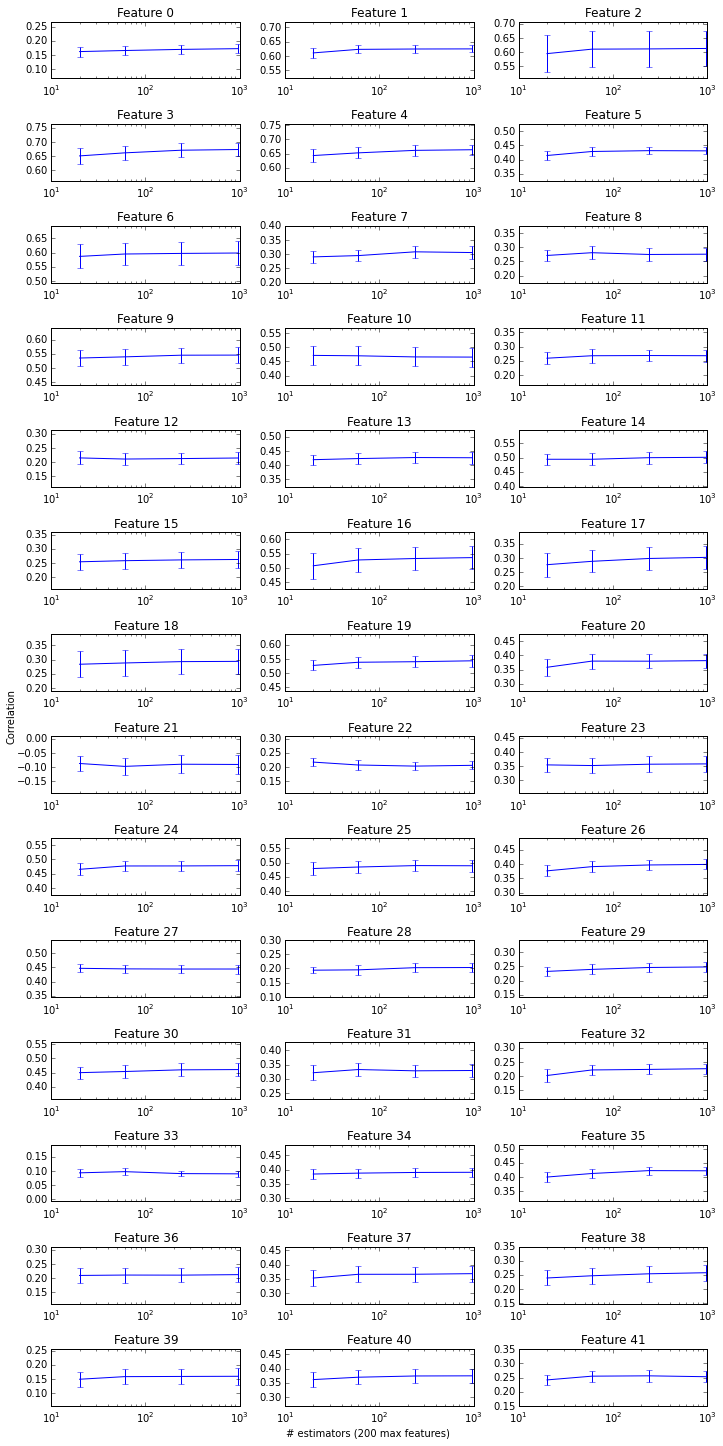

In [130]:
fig,axes = plt.subplots(14,3,sharex=False,sharey=False,figsize=(10,20))
for col,ax in enumerate(axes.flat):
    ax.errorbar([20,60,240,960],results_n_estimators[col,:,:].mean(axis=1),results_n_estimators[col,:,:].std(axis=1)/np.sqrt(n_splits))
    ax.set_xlim(10,1000)
    mean = results_n_estimators[col,:,:].mean()
    ax.set_ylim(mean-0.1,mean+0.1)
    #ax.set_yticks(np.linspace(0,0.6,4))
    #ax_.set_xticklabels(n_features,rotation=45)
    ax.set_xscale('log')
    ax.set_title('Feature %d' % col)
plt.tight_layout()
fig.text(0.5, 0.00, '# estimators (200 max features)', ha='center')
fig.text(0.00, 0.5, 'Correlation', va='center', rotation='vertical')

/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


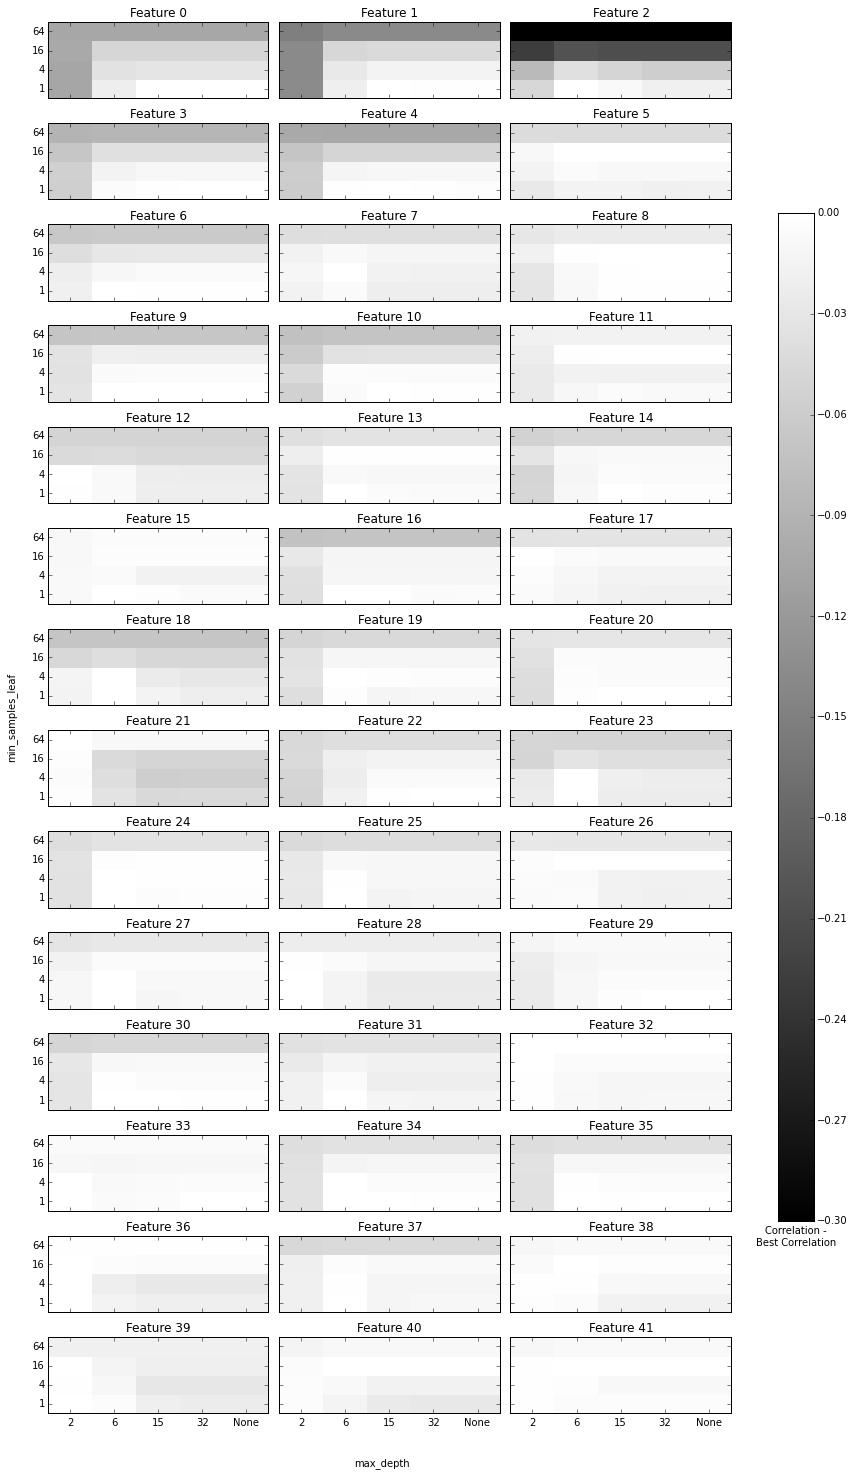

In [46]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(14,3,sharex=True,sharey=True,figsize=(10,20))
for col,ax in enumerate(axes.flat):
    im = ax.pcolormesh(results[col,:,:,:].mean(axis=2)-results[col,:,:,:].mean(axis=2).max(),vmin=-0.3,vmax=0.0,cmap='gray')
    ax.set_xticks(np.arange(5)+0.5)
    ax.set_xticklabels(n_depth)
    ax.set_yticks(np.arange(4)+0.5)
    ax.set_yticklabels(n_samples_leaf)
    ax.set_title('Feature %d' % col)
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar_ax.set_xlabel('Correlation - \nBest Correlation')
plt.colorbar(im, cax=cbar_ax)
fig.text(0.5, -0.02, 'max_depth', ha='center')
fig.text(-0.02, 0.5, 'min_samples_leaf', va='center', rotation='vertical')
plt.tight_layout()

In [44]:
# Now we focus just on max_depth?  
n_splits = 10
n_depth = [2,5,8,12,16,25,None]
results = np.zeros((42,len(n_depth),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    for j,max_depth in enumerate(n_depth):
        rfc = RandomForestRegressor(n_estimators=10,max_features=None,
                                        min_samples_leaf=1,
                                        max_depth=max_depth,oob_score=False,
                                        n_jobs=-1,random_state=0)
        X = X_all['dragon+all']
        Y = Y_all_mask['mean_std'][:,col]
        for k,(train,test) in enumerate(shuffle_split):
            observed = Y[test]
            rfc.fit(X[train,:],Y[train])
            predicted = rfc.predict(X[test,:])
            results[col,j,k] = np.corrcoef(predicted,observed)[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)
    print(('Desc. %d:'+len(n_depth)*' [%.3f],') % \
          tuple([col]+[means[i] for i in range(len(n_depth))]))

Desc. 0: [0.509], [0.566], [0.577], [0.581], [0.579], [0.576], [0.576],
Desc. 1: [0.502], [0.600], [0.619], [0.623], [0.622], [0.618], [0.617],
Desc. 2: [0.547], [0.588], [0.593], [0.591], [0.584], [0.576], [0.573],
Desc. 3: [0.524], [0.624], [0.642], [0.640], [0.649], [0.641], [0.641],
Desc. 4: [0.548], [0.651], [0.664], [0.675], [0.663], [0.667], [0.672],
Desc. 5: [0.393], [0.415], [0.399], [0.407], [0.409], [0.399], [0.402],
Desc. 6: [0.589], [0.630], [0.606], [0.604], [0.604], [0.605], [0.604],
Desc. 7: [0.312], [0.330], [0.304], [0.283], [0.280], [0.290], [0.285],
Desc. 8: [0.216], [0.267], [0.282], [0.291], [0.287], [0.281], [0.286],
Desc. 9: [0.452], [0.541], [0.542], [0.537], [0.535], [0.534], [0.531],
Desc. 10: [0.335], [0.437], [0.449], [0.444], [0.451], [0.451], [0.447],
Desc. 11: [0.380], [0.394], [0.380], [0.389], [0.384], [0.383], [0.382],
Desc. 12: [0.257], [0.232], [0.209], [0.207], [0.204], [0.207], [0.208],
Desc. 13: [0.347], [0.414], [0.416], [0.402], [0.400], [0.404

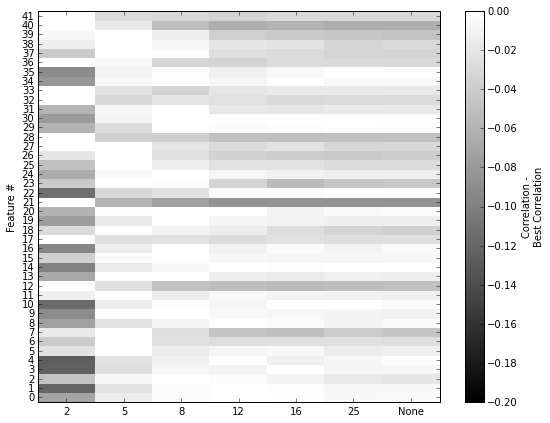

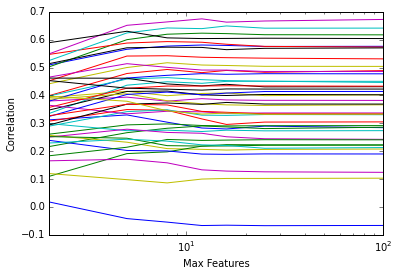

In [45]:
# Visualizing the dependence on n_depth
plt.figure(figsize=(9,7))
plt.pcolormesh(results.mean(axis=2) - np.tile(results.mean(axis=2).max(axis=1),(7,1)).T, vmin=-0.2, vmax=0.0)
plt.xticks(np.arange(len(n_depth))+0.5,n_depth)
plt.yticks(np.arange(42)+0.5,np.arange(42))
plt.ylim(0,42)
plt.ylabel('Feature #')
plt.set_cmap('gray')
ax = plt.colorbar()
ax.set_label('Correlation - \nBest Correlation')
plt.figure()
n_depth_ = [_ if _ is not None else 100 for _ in n_depth]
plt.plot(n_depth_,results[:,:,:].mean(axis=2).T)
plt.xscale('log')
plt.xlabel('Max Features')
plt.ylabel('Correlation')
_ = plt.xlim(2,100)

0 [ 0.71787708  1.0783493 ]
1 [ 0.53926198  1.11949144]
2 [ 0.92942102  1.16972938]
3 [ 0.77463092  1.13112086]
4 [ 0.86310257  1.14042383]
5 [ 1.14091214  1.30928986]
6 [ 0.90388954  1.14596541]
7 [ 0.92814885  1.21977815]
8 [ 1.01172533  1.22356058]
9 [ 0.89110208  1.19840522]
10 [ 0.94056219  1.21105179]
11 [ 0.89759906  1.23709485]
12 [ 1.00520858  1.27475276]
13 [ 0.91949363  1.23973119]
14 [ 1.02708055  1.27648987]
15 [ 1.05155092  1.26929085]
16 [ 0.95116679  1.19434156]
17 [ 1.13320597  1.3030216 ]
18 [ 1.07812377  1.25676318]
19 [ 0.90582241  1.13672918]
20 [ 0.80440721  1.12741897]


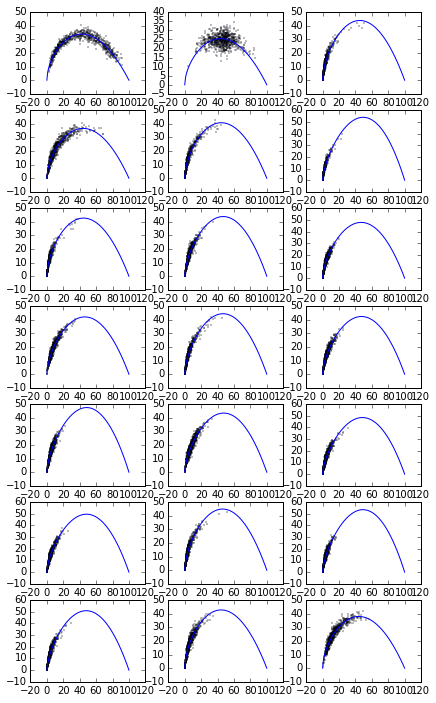

In [30]:
def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))
    
def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    #predicted_mean = f_transformation2(predicted[i], k0=x[0], k1=x[1], k2=x[2])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse
    
fig,axes = plt.subplots(7,3,figsize=(7,12))
ax = axes.flat
f_coefs = {col:None for col in range(21)}
from scipy.optimize import minimize
for col in range(len(ax)):    
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
    x = [1.0,1.0]
    res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
    print(col,res.x)
    f_coefs[col] = res.x
    ax[col].scatter(Y_mean,Y_stdev,s=0.1)
    x_ = np.linspace(0,100,100)
    ax[col].plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]))#, k2=res.x[2]))

In [31]:
# Balance between directly fitting stdev and applying a function to the fit of the mean.  

n_splits = 10
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
#predictions_mean = {i:[None]*n_splits for i in range(21)}
#predictions_stdev = {i:[None]*n_splits for i in range(21)}
for col in range(21):
    X = X_all['dragon+all']
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
              
    for k,(train,test) in enumerate(shuffle_split):
        print(col,k)
        rfc_mean = RandomForestRegressor(n_estimators=30,max_features=None,
                                        min_samples_leaf=1,
                                        max_depth=None,
                                        n_jobs=-1,random_state=0)
        rfc_stdev = RandomForestRegressor(n_estimators=30,max_features=None,
                                        min_samples_leaf=1,
                                        max_depth=None,
                                        n_jobs=-1,random_state=0)
    
        rfc_mean.fit(X[train,:],Y_mean[train])
        rfc_stdev.fit(X[train,:],Y_stdev[train])
        predictions_mean[col][k] = rfc_mean.predict(X[test,:])
        predictions_stdev[col][k] = rfc_stdev.predict(X[test,:])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9


0 1.0
1 0.0294117647059
2 1.0
3 0.617647058824
4 0.794117647059
5 0.970588235294
6 0.676470588235
7 0.882352941176
8 1.0
9 0.764705882353
10 0.911764705882
11 0.5
12 1.0
13 0.352941176471
14 0.676470588235
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 0.382352941176


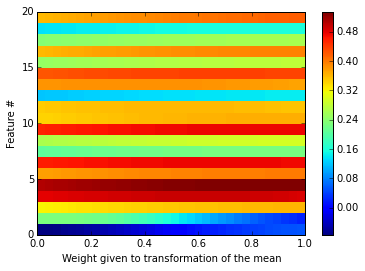

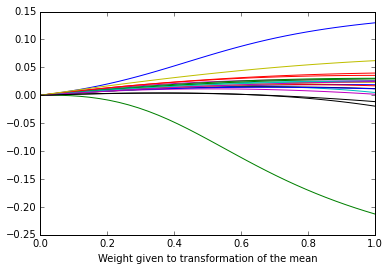

In [40]:
# Balance between directly fitting stdev and applying a function to the fit of the mean.  

results = np.zeros((21,n_splits,35))
#predictions_mean = {i:[None]*n_splits for i in range(21)}
#predictions_stdev = {i:[None]*n_splits for i in range(21)}
for col in range(21):
    X = X_all['dragon+all']
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
              
    for k,(train,test) in enumerate(shuffle_split):
        observed = Y_stdev[test]
        p_m = predictions_mean[col][k]
        p_s = predictions_stdev[col][k]
        for i,a in enumerate(np.linspace(0,1,35)):
            p_s_transformed = f_transformation(p_m, k0=f_coefs[col][0], k1=f_coefs[col][0])
            predicted = a*p_s_transformed + (1-a)*p_s
            results[col,k,i] = np.corrcoef(predicted,observed)[1,0]
plt.pcolormesh(np.linspace(0,1,35),np.arange(21),results.mean(axis=1))# - np.tile(results.mean(axis=1).max(axis=1),(35,1)).T)
plt.xlabel('Weight given to transformation of the mean')
plt.ylabel('Feature #')
plt.colorbar()
plt.figure()
plt.plot(np.linspace(0,1,35),results.mean(axis=1).T-results.mean(axis=1)[:,0])
plt.xlabel('Weight given to transformation of the mean')
for col in range(21):
    max_loc = np.argmax(results.mean(axis=1)[col,:])
    print(col,np.linspace(0,1,35)[max_loc])

In [26]:
write = True # Set to True to actually generate the prediction files.  
n_estimators = 1000 # Set this to a high number (e.g. 1000) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':{'mean':None,'sigma':None},
                'ple':{'mean':None,'sigma':None},
                'dec':{'mean':None,'sigma':None}}
min_samples_leaf = {'int':{'mean':1,'sigma':4},
                'ple':{'mean':1,'sigma':1},
                'dec':{'mean':1,'sigma':1}}
max_depth = {'int':{'mean':None,'sigma':2},
                'ple':{'mean':10,'sigma':10},
                'dec':{'mean':10,'sigma':10}}
et = {'int':{'mean':True,'sigma':True},
                'ple':{'mean':False,'sigma':False},
                'dec':{'mean':False,'sigma':False}}
#et['int'] = {'mean':False,'sigma':False} # Uncomment to get a correct score estimate, or leave commented to get best fit.  
use_mask = {'int':{'mean':False,'sigma':True},
                'ple':{'mean':False,'sigma':True},
                'dec':{'mean':False,'sigma':True}}

In [27]:
for mdt in molecular_data_types:
    print(mdt)
    loading.make_prediction_files(rfcs_leaderboard[mdt],X_leaderboard_int[mdt],X_leaderboard_other[mdt],
                                  'leaderboard_%s' % mdt,2,Y_test=Y_leaderboard_noimpute,write=False)

dragon
Score: 8.614029; rs = 0.658,0.517,0.522,0.385,0.244,0.479
dragon+episuite
Score: 8.716942; rs = 0.665,0.509,0.535,0.372,0.238,0.487
dragon+verbal
Score: 8.299890; rs = 0.662,0.498,0.506,0.260,0.274,0.468
dragon+morgan
Score: 8.746169; rs = 0.650,0.532,0.535,0.330,0.272,0.492
dragon+nspdk
Score: 9.138397; rs = 0.684,0.577,0.551,0.447,0.256,0.500
dragon+nspdk_gramian
Score: 8.953301; rs = 0.633,0.571,0.543,0.429,0.233,0.499
dragon+all
Score: 9.055417; rs = 0.648,0.573,0.555,0.371,0.273,0.504


In [28]:
rs_ = [[0.658,0.517,0.522,0.385,0.244,0.479],[0.665,0.509,0.535,0.372,0.238,0.487],[0.662,0.498,0.506,0.260,0.274,0.468],
[0.650,0.532,0.535,0.330,0.272,0.492],[0.684,0.577,0.551,0.447,0.256,0.500],[0.655,0.551,0.535,0.269,0.311,0.486]]
for i,challenge in enumerate(rs_):
    print(molecular_data_types[i]+'\t'.join(str(x) for x in challenge))
        

dragon0.658	0.517	0.522	0.385	0.244	0.479
dragon+episuite0.665	0.509	0.535	0.372	0.238	0.487
dragon+verbal0.662	0.498	0.506	0.26	0.274	0.468
dragon+morgan0.65	0.532	0.535	0.33	0.272	0.492
dragon+nspdk0.684	0.577	0.551	0.447	0.256	0.5
dragon+all0.655	0.551	0.535	0.269	0.311	0.486


In [29]:
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

For subchallenge 2:
	Score = 2.83
	int_mean = 1.000
	int_sigma = 0.126
	ple_mean = 0.009
	ple_sigma = -0.010
	dec_mean = 0.133
	dec_sigma = 0.072


In [30]:
loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=False)

{'mean_std': array([[ 33.26530612,  44.62244898,   2.12244898, ...,   9.93389033,
          10.11045229,  21.72142009],
        [ 12.95918367,  48.15306122,   0.91836735, ...,   7.59583474,
          18.41829388,  22.26213039],
        [ 21.16326531,  44.62244898,   8.12244898, ...,   4.7887756 ,
           8.37787436,  24.78012562],
        ..., 
        [ 39.53061224,  59.50204082,   3.82780612, ...,  12.27196668,
          22.87507041,  19.62084018],
        [ 18.3877551 ,  57.82653061,   1.42212675, ...,   8.39165909,
          14.20939341,  23.09079336],
        [ 29.08163265,  49.21836735,   3.95918367, ...,  11.30602357,
          31.18954828,  22.55003619]]), 'subject': {}}